# Bayesian Causal Inference in Non-Randomized Experiments

**Author**: Leo Guelman

* [1. Problem Statment](#problem1)
    * [1.1 The National Study of Learning Mindsets](#mindsets11)
    * [1.2 Data Description](#data12)
    * [1.2 The Questions](#questions13)
* [2. Analysis](#analysis2) 
    * [2.1 Imports](#imports21)
    * [2.2 Data](#data22)
    * [2.3 Assessing Balance of Covariates](#balance23)
    * [2.4 Propensity score](#propscore24)
    * [2.5 Model-based Inference](#mbinference25)
        * [2.5.1 MCMC Diagnostics](#mcmcdiagn251)
        * [2.5.2 Effectivness of Intervention](#effint252)
        * [2.5.3 Treatment effect variation across](#hetero253)
        * [2.5.3 Individual Treatment Effects](#ite254)
 

# 1. Problem Statment <a class="anchor" id="problem1"></a>

## 1.1 The National Study of Learning Mindsets <a class="anchor" id="mindsets11"></a>

We look at the causal inference challenge presented by the *National Study of Learning Mindsets* (Yeager et al., 2019) from a Bayesian perspective. 

The NSLM is a randomized experiment designed to assess the effectiveness of an intervention to improve academic outcomes of students with a *growth mindset*. The *growth mindset* is a belief that people can develop intelligence, as opposed to the *fixed mindset* view which sees intelligence as an innate trait that is fixed at birth.

The original study consisted in a randomized experiment composed of students from 76 schools drawn from the national probability sample of U.S. public schools. In addition, to assessing the average treatment effect (ATE), the study was designed to estimate the degree of heterogeneity in treatment effect across both students and schools. 

A synthetic dataset was generated to mimic the original data, but with the goal of creating an observational study that includes confounding effects not present in the original randomized experiment. Besides this difference, the synthetic data resembles the real NSLM data in terms of covariate distribution, data structures, and effect sizes. 

During the 2018 Atlantic Causal Inference Conference (ACIC 2018), eight groups of participans were invited to analyze the synthetic data to assess the questions of average treatment effect and treatment effect variation in non-randomized experimental settings. Participants employed a diverse set of methods, ranging from matching and flexible outcome modeling to semiparametric estimation and ensemble approaches. In this study, we employ an alternative approach founded in Bayesian inference principles.

## 1.2 Data Description <a class="anchor" id="data12"></a>

The analysis is based on the sythetic dataset of $n=10,391$ children from a sample of $J=76$ schools. For each children $i=\{1, \ldots, n\}$, we observe a binary treatment indicator $Z_i$, a real-valued outcome $Y_i$, as well as 10 categorical or real-valued covariates as outlined in the table below. For a full description of the data generating process refer to Carvalho et al., 2019.


| Covariate | Description |
| :---        |    :----   | 
| S3 | Student’s self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment|
| C1 | Categorical variable for student race/ethnicity |
|C2 | Categorical variable for student identified gender
|C3 | Categorical variable for student first-generation status, i.e. first in family to go to college
|XC | School-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc.
| X1 | School-level mean of students’ fixed mindsets, reported prior to random assignment
| X2|  School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students
|X3  | School racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American
| X4 | School poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line
| X5 | School size, i.e., total number of students in all four grade levels in the school
| Y | Post-treatment outcome, a continuous measure of achievement
|Z | Treatment, i.e., receipt of the intervention





## 1.3 The Questions <a class="anchor" id="questions13"></a>

The two questions we are aiming to address as part of this study are the following:

1. Was the mindset intervention effective in improving student achievement?
2. Was the effect of the intervention moderated by school level achievement (`X2`) or pre-existing mindset norms (`X1`)? In particular there are two competing hypotheses about how `X2` moderates the effect of the intervention: Either it is largest in middle-achieving schools (a "Goldilocks effect") or is decreasing in school-level achievement.


# 2. Analysis <a class="anchor" id="analysis2"></a>

## 2.1 Imports <a class="anchor" id="imports21"></a>

In [1]:
import os
os.chdir('/Users/lguelman/Library/Mobile Documents/com~apple~CloudDocs/LG_Files/Development/BCI/python')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
parameters = {'figure.figsize': (8, 4),
              'font.size': 8, 
              'axes.labelsize': 12}
plt.rcParams.update(parameters)
plt.style.use('fivethirtyeight')
from IPython.display import Image

import pystan
import multiprocessing
import stan_utility
import arviz as az

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

import seaborn as sns

from acic_utils import pre_process_data, stan_model_summary

## 2.2 Data  <a class="anchor" id="data22"></a>

In [2]:
df = pd.read_csv("../data/synthetic_data.csv")
df
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   schoolid  10391 non-null  int64  
 1   Z         10391 non-null  int64  
 2   Y         10391 non-null  float64
 3   S3        10391 non-null  int64  
 4   C1        10391 non-null  int64  
 5   C2        10391 non-null  int64  
 6   C3        10391 non-null  int64  
 7   XC        10391 non-null  int64  
 8   X1        10391 non-null  float64
 9   X2        10391 non-null  float64
 10  X3        10391 non-null  float64
 11  X4        10391 non-null  float64
 12  X5        10391 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 1.0 MB


,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
count,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000
mean,39.888846,0.325666,-0.096742,5.268117,5.223078,1.489943,0.630931,2.447791,-0.040457,0.054841,-0.089349,-0.045911,-0.026168
std,24.008975,0.468646,0.643009,1.120765,3.982963,0.499923,0.482576,1.378420,0.969743,0.935560,0.962804,0.967262,1.010387
min,1.000000,0.000000,-2.097420,1.000000,1.000000,1.000000,0.000000,0.000000,-3.088790,-3.347819,-1.575463,-1.924778,-1.805073
25%,19.000000,0.000000,-0.548980,5.000000,3.000000,1.000000,0.000000,1.000000,-0.617888,-0.544506,-0.963095,-0.813799,-0.857026
50%,41.000000,0.000000,-0.118923,5.000000,4.000000,1.000000,1.000000,2.000000,-0.009954,-0.022514,-0.057036,-0.159602,-0.211553
75%,62.000000,1.000000,0.335663,6.000000,5.000000,2.000000,1.000000,4.000000,0.420441,0.726836,0.515392,0.596474,0.847844
max,76.000000,1.000000,2.194709,7.000000,15.000000,2.000000,1.000000,4.000000,2.834589,2.171815,2.358274,2.821660,1.892348


## 2.3 Assessing Balance of Covariates <a class="anchor" id="balance23"></a>

Covariate balance is the degree to which the distribution of covariates is similar across levels of the treatment. Here we assess the extent to which the treatment assignment was uniformly randomized across observational units, or there are some selection effects. To that end, we use *Prognostic scores* (Hansen 2008). The prognostic score is defined as the predicted outcome under the control condition, reflecting the baseline "risk", i.e., $E(Y|X, Z=0)$. It is estimated by fitting a model of the outcome in the control group, and then using that model to obtain predictions of the outcome under the control condition for all individuals. The standardize difference in the mean prognostic scores between treatment and control groups is used as a measure of covariate balance. 

Here we fit a Bayesian linear regression model to get a posterior distribution of the standardize difference in the mean prognostic scores between treatment and control groups.

We first pre-process the data (encode categorical features and scaling).

In [3]:
X, z, y, *_ = pre_process_data(df, standardize_x=False, interactions=False, 
                               p_score=None, drop_first=False)

print("Features dimension:", X.shape)
print("Treatment dimension:", z.shape)
print("Response dimension:", y.shape)
print("Number of treated / control units:", sum(z), "/", X.shape[0]-sum(z))

Features dimension: (10391, 28)
Treatment dimension: (10391,)
Response dimension: (10391,)
Number of treated / control units: 3384 / 7007


We now fit the model in [stan](https://mc-stan.org/). We place the stan code separately in `stan_linear_reg.stan`, stored in the repo.

In [4]:
n, p = X[z==0,:].shape # Fit model using control units only

stan_data_dict = {'N': n,
                  'K': p,
                  'x': X[z==0,:],
                  'y': y[z==0],
                  'N_new': X.shape[0],
                  'x_new': X
                  }

sm = pystan.StanModel('../stan/stan_linear_reg.stan') 
multiprocessing.set_start_method("fork", force=True)
fit = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8096660a52168d4061eab351075ddfd3 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [5]:
fit_summary = stan_model_summary(fit)
fit_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,-5.238534,5.885756,12.588739,-26.605117,-16.537062,-4.240195,2.809899,19.665753,4.574672,2.028383
beta[1],0.232894,0.000481,0.005405,0.222040,0.229219,0.232860,0.236594,0.243329,126.298196,1.058522
beta[2],-0.167606,0.001188,0.012377,-0.190331,-0.176427,-0.168166,-0.159499,-0.142454,108.605109,1.064856
beta[3],-0.097198,0.001470,0.013525,-0.121366,-0.106434,-0.097916,-0.087805,-0.068684,84.619702,1.049591
beta[4],-0.068400,0.000763,0.008794,-0.085158,-0.074363,-0.068438,-0.062435,-0.051303,132.883928,1.009924
...,...,...,...,...,...,...,...,...,...,...
prog_scores[10388],5.237922,5.895180,12.603150,-19.642750,-2.858228,4.303518,16.521053,26.707137,4.570504,2.025223
prog_scores[10389],4.424376,5.878793,12.600082,-20.350253,-3.652748,3.379425,15.634531,25.727524,4.593782,2.015619
prog_scores[10390],4.974672,5.900855,12.600318,-19.781063,-2.985285,3.946155,16.185408,26.281914,4.559667,2.029400
prog_scores[10391],4.910103,5.873613,12.588250,-19.770399,-3.155080,3.991522,16.146388,26.174217,4.593250,2.020887


The standardize mean difference in Prognostic scores is positive meaning that students with highest potential outcomes under control are more likely to receive treatment. This can also be appreciated by plotting the proportion of individuals assigned to treatment for by quantile of the prognostic score (each quantile comprises about 1/5 of the observations). In this case, we say that the treatment assignment mechanisms is *counfounded* with the potential outcomes.

In this context, a simple comparison of treated versus control individuals would produce bias estimates of treatment effects (both average and conditional effects). Therefore, appropriately accounting for confounding is a first-order concern. We thus proceed the analysis as an observational study instead on a randomized one. Specifically, to address this problem we directly incorporate an estimate of the *propensity score* in the specification of the outcome model, implicitly inducing a covariate dependent prior on the regression function (see Hahn 2020).




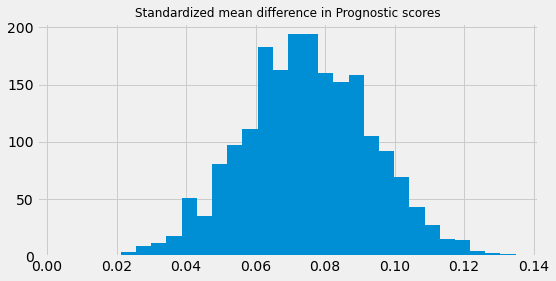

In [6]:
# Extract prognostic scores
samples = fit.extract(permuted=True)
prog_scores = samples['prog_scores'].T

# Compute mean and standardize mean differences in scores
mcmc_samples = prog_scores.shape[1]
prog_scores_diff = np.zeros(mcmc_samples)
prog_scores_std_diff = np.zeros(mcmc_samples)

for s in range(mcmc_samples):
    prog_scores_diff[s] = np.mean(prog_scores[z==1,s]) - np.mean(prog_scores[z==0,s])
    prog_scores_std_diff[s] = prog_scores_diff[s] / np.std(prog_scores[:,s])
  
                               
plt.hist(prog_scores_std_diff, bins = 30)
plt.title("Standardized mean difference in Prognostic scores", fontsize=12)
plt.show()  


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


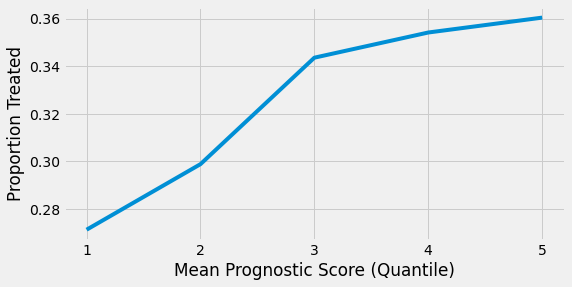

In [7]:
# Compute proportion treated by mean prognostic score quantile
prog_scores_df = pd.DataFrame({'prog_score_mean': np.mean(prog_scores, axis =1),'z':z})
prog_scores_df['prog_score_mean_quantile']= pd.qcut(prog_scores_df['prog_score_mean'], 
                                                    q = 5, labels = False)+1
prog_scores_df.groupby(['prog_score_mean_quantile'])['z'].mean().plot(xticks=list(range(1,6)), 
                                                                     xlabel='Mean Prognostic Score (Quantile)',
                                                                     ylabel='Proportion Treated')

## 2.4 Propensity Score <a class="anchor" id="propscore24"></a>

The propensity score is the probability of treatment assignment conditional on observed baseline covariates, i.e., $E(Z|X)$. Here we fit the propensity score using a flexible non-linear specification based on a Gradient Boosting method. Parameter tuning is done via cross-validated random search.

In [8]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

n_folds = 3
param_n_picks = 30

xgb = XGBClassifier(learning_rate=0.01, n_estimators=500, objective='binary:logistic',
                    silent=True, nthread=1)

skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)

xgb_fits = RandomizedSearchCV(xgb, param_distributions=param_grid,
                              n_iter=param_n_picks, scoring='roc_auc', n_jobs=-1, 
                              cv=skf.split(X,z), verbose=3, random_state=42)

xgb_fits.fit(X, z)

print('\n Best estimator:')
print(xgb_fits.best_estimator_)
#print('\n Best AUC score:')
#print(xgb_fits.best_score_)
print('\n Best hyperparameters:')
print(xgb_fits.best_params_)

# We now fit the best estimator to all train data 
best_fit = xgb_fits.best_estimator_.fit(X, z)
pscore = best_fit.predict_proba(X)[:,1]
log_odds_pscore = np.log(pscore /(1-pscore))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished
/Users/lguelman/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:12:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=nan, monotone_constraints

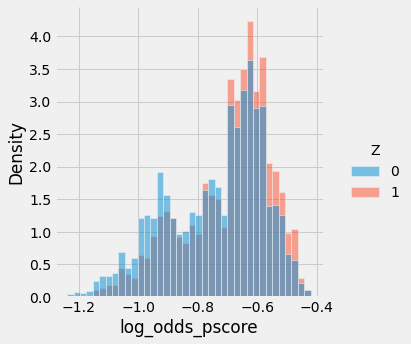

In [9]:
prop_score_df = pd.DataFrame({'log_odds_pscore': log_odds_pscore, 'Z':z})
sns.displot(prop_score_df, x="log_odds_pscore", 
            hue="Z",  stat="density", common_norm=False)

## 2.5 Model-based Inference <a class="anchor" id="mbinference25"></a>


We implement the Bayesian inference framework for causal effects introduced by Rubin (1978). In this framework, each observational unit $i=\{1,\ldots, N\}$ is seen as having a potential outcome for each level of treatment. In the binary treatment case with $Z \in [0,1]$, $Y_i(1)$ and $Y_i(0)$ represent the potential outcomes of unit $i$ under $Z=1$ and 
$Z=0$, respectively. Causal inference is considered a missing data problem since both potential outcomes are never jointly observed. Specifically, observed and missing outcomes can be expressed in terms of the potential outcomes as follows:

\begin{align*} 
Y_i^{\text{obs}} &=  Y_i(1)Z_i + Y_i(0)(1-Z_i) \\ 
Y_i^{\text{mis}} &=  Y_i(1)(1-Z_i) + Y_i(0)Z_i
\end{align*}


From a Bayesian perspective, $Y_i^{\text{mis}}$ is considered a latent variable, similar to any other latent variable in the model (I'm trying to avoid the term "parameters" here, which is more common in the frequentist language). The missing potential outcomes can be imputed by estimating their posterior predictive distribution given the observed data. That is,

$$
\text{Pr}(Y^{\text{mis}}| Y^{\text{obs}},Z, X).
$$

Estimating the conditional distribution of $Y^{\text{mis}}$ given $(Y^{\text{obs}},Z, X)$, requires building a model of the joint distribution of potential outcomes $(Y(0), Y(1))$. We assume that the true underlying model for the potential outcomes follows a bivariate Gaussian, 

$$
\begin{pmatrix}
Y_i(0) \\
Y_i(1) 
\end{pmatrix} \bigg\lvert~X_i, \theta \sim N \left(\begin{pmatrix}
\alpha + X_i\beta_c \\
\alpha + X_i\beta_t + \tau
\end{pmatrix},\begin{pmatrix}
\sigma_c^{2} & \rho\sigma_c\sigma_t \\
\rho\sigma_c\sigma_t & \sigma_t^{2}
\end{pmatrix}\right),
$$

where $\theta=(\alpha, \beta_c, \beta_t, \tau, \sigma_c^2, \sigma_t^2, \rho)$.

From this model, we can derive the conditional distribution of each potential outcome as


\begin{align*} 
\text{Pr}(Y_i(1) | Y_i(0), \theta, Z_i=0) &\sim N \Big(\mu_t+ \rho \frac{\sigma_t}{\sigma_c} (Y_i(0)-\mu_c), \sigma^2_t(1-\rho^2)\Big),\\
\text{Pr}(Y_i(0) | Y_i(1), \theta, Z_i=1) &\sim N \Big(\mu_c+ \rho \frac{\sigma_c}{\sigma_t} (Y_i(1)-\mu_t), \sigma^2_c(1-\rho^2)\Big), 
\end{align*}

where $\mu_c = \alpha + X\beta_c$, and $\mu_t = \alpha + X\beta_t + \tau$.

From the distribution of potential outcomes, we can infer the distribution of any estimand of interest of the form $\tau = \tau(Y(0),Y(1), X, Z)$. For instance, the average treatment effect (ATE) can be obtained by simply computing $\frac{1}{N}\sum_{i=1}^N(Y_i(1)-Y_i(0))$. This is also known as the "finite sample" ATE. If instead, we view the observations as a sample from an infinite super-population, then the super-population ATE is given from the posterior distribution of $\tau$.

A few observations from the model above:

* Since $Y_i(0)$ and $Y_i(1)$ are never jointly observed, the correlation between outcomes, $\rho$, cannot be estimated empirically. It must be based on subject-matter knowledge. Sometimes we may choose to be "conservative" about this dependence and therefore assume the worst case. In terms of the posterior variance, the worst case is often the situation of perfect correlation between the two potential outcomes.

* There are two sources of uncertainty in the predictive distribution of the missing potential outcomes: the first is the uncertainty in the estimated latent variables (a.k.a., *epistemic uncertainty*), and the second in the uncertainty in the data as expressed by the Gaussian random sampling mechanism (a.k.a., *aleatoric uncertainty*).

* We allow for heterogeneous treatment effects - i.e., we define two different vectors $\beta_c$ and  $\beta_t$, for control and treated units, respectively. In the **Stan** model below (see `stan_mbi.stan`), this heterogeneity is expressed by including interaction terms between each covariate and the treatment. The posterior estimates on the interaction effects represent the incremental effect of treatment $\beta_t - \beta_c$.

* The propensity score is considered as an additional covariate in $X$.



In [10]:
X,z, y, a_effects, m_effects, i_effects = pre_process_data(df, standardize_x=False, interactions=True, 
                                                            p_score=pscore, drop_first=False)

# Get indexes of main and interaction effects
idx_m_effects = [a_effects.index(i) for i in m_effects]
idx_i_effects = [a_effects.index(i) for i in i_effects]

print(X.shape)
print(len(idx_m_effects))
print(len(idx_i_effects))
print(X[:,idx_m_effects].shape)
print(X[:,idx_i_effects].shape)

(10391, 58)
29
29
(10391, 29)
(10391, 29)


In [11]:
stan_data_mbi = {'N': X.shape[0], 
                 'N_main_cov':len(idx_m_effects),
                 'N_inter_cov':len(idx_i_effects),
                 'y': y,
                 'z': z,
                 'x': X[:,idx_m_effects],
                 'xz_inter': X[:,idx_i_effects],
                 'rho':0.0}

sm = pystan.StanModel('../stan/stan_mbi.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_mbi = sm.sampling(data=stan_data_mbi, iter=1000, chains=4, seed=194838)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_60991e207af6827951ca148d0742491d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### 2.5.1 MCMC Diagnostics <a class="anchor" id="mcmcdiagn251"></a>


In [12]:
summary_stan_fit = stan_model_summary(fit_mbi)
summary_stan_fit

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,-1.528304,0.693496,3.212315,-7.570534,-3.788758,-1.466491,0.564333,4.989348,21.456011,1.211422
beta[1],0.196362,0.000875,0.009929,0.176052,0.189962,0.196349,0.202961,0.215980,128.715076,1.030324
beta[2],-0.143101,0.001229,0.014045,-0.170103,-0.152569,-0.143146,-0.134007,-0.115498,130.532297,1.037132
beta[3],-0.058852,0.001615,0.017272,-0.090583,-0.070745,-0.059339,-0.047720,-0.022832,114.410890,1.039459
beta[4],-0.043382,0.000778,0.010198,-0.063602,-0.050343,-0.043308,-0.036262,-0.023320,171.862733,1.019397
...,...,...,...,...,...,...,...,...,...,...
tau_unit[10388],0.422756,0.011818,0.539426,-0.689171,0.075395,0.434672,0.765118,1.482047,2083.253191,0.998910
tau_unit[10389],-0.936938,0.012161,0.533103,-1.972346,-1.298663,-0.944824,-0.580085,0.143458,1921.826441,0.999979
tau_unit[10390],0.120828,0.011447,0.532955,-0.925286,-0.234366,0.122399,0.495573,1.149292,2167.578426,0.999434
tau_unit[10391],-0.563016,0.012717,0.544431,-1.671883,-0.938285,-0.563197,-0.187035,0.497794,1832.924103,1.000102


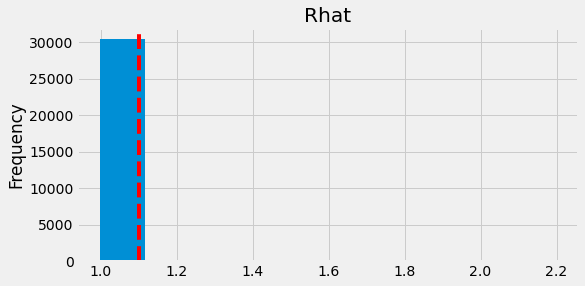

In [13]:
r_hat = summary_stan_fit['Rhat']
r_hat.plot.hist(title="Rhat")
plt.axvline(1.1, color='r', linestyle='--')

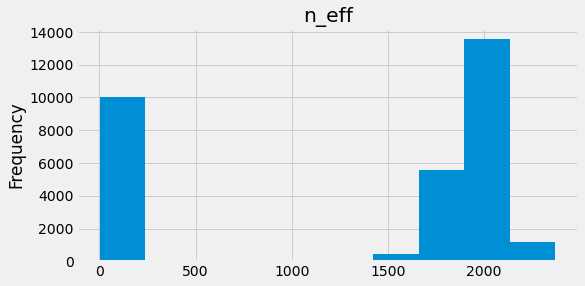

In [14]:
summary_stan_fit['n_eff'].plot.hist(title="n_eff")

In [15]:
stan_utility.utils.check_treedepth(fit_mbi)

2000 of 2000 iterations saturated the maximum tree depth of 10 (100.0%)
  Run again with max_treedepth set to a larger value to avoid saturation


In [16]:
stan_utility.utils.check_energy(fit_mbi)

E-BFMI indicated no pathological behavior


In [17]:
stan_utility.utils.check_div(fit_mbi)

0.0 of 2000 iterations ended with a divergence (0.0%)


### 2.5.2  Effectiveness of Intervention<a class="anchor" id="effint252"></a>

Here we address the first study question, which we recall is "*Was the mindset intervention effective in improving student achievement?*" This relates to the *Average Treatment Effect (ATE)*. The estimated (finite-sample) **ATE is 0.24 with a 95% uncertainty interval between 0.22 and 0.26. The true value based on the simulation is also 0.24**, so we are right on spot. 

In [70]:
taus = summary_stan_fit.loc[['tau_fs']]
taus

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
tau_fs,0.240261,0.000194,0.008324,0.223899,0.234661,0.24039,0.245908,0.256844,1832.438293,1.001269


For comparison purposes, we show below the submitted estimates for average treatment effects and corresponding 95% uncertainty intervals from eight ACIC 2018 challenge participants (Carvalho 2019). Our estimate is closer to the true value relative to all submissions.

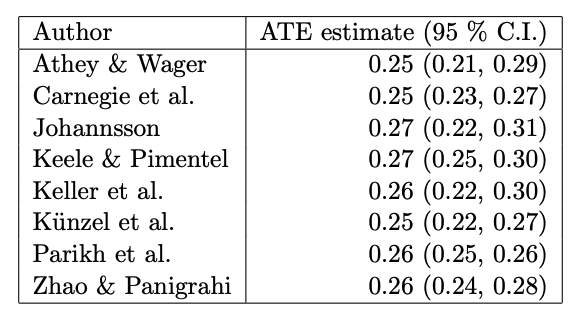

In [19]:
Image(filename = "../img/acic_ate.png", width = 300, height = 200)

### 2.5.3  Treatment effect variation across `X1` and `X2` <a class="anchor" id="hetero253"></a>

The second question of the study is directed to assess the treatment effect variation across the two pre-specified moderators, `X1` (pre-existing mindset norms) and `X2` (school level achievement).

We look at the posterior estimates of interaction effects `Z x X1` and `Z x X2`. This effect represent the incremental effect of treatment $\beta_t - \beta_c$ from `X1` and `X2`. The results depicted below indicate that a higher baseline mindset beliefs tends to be associated with lower treatment effect on average. In contrast, there appears to be no support for treatment effect variation across school achievement levels. 

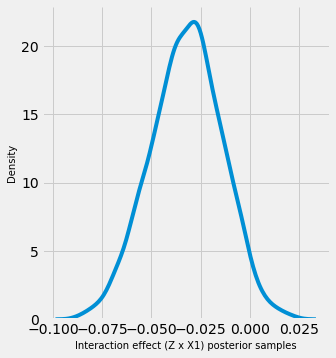

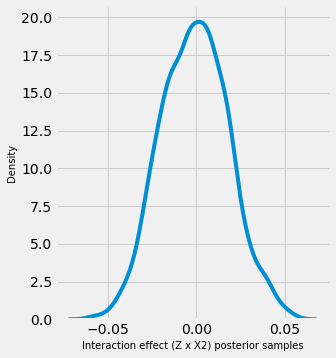

In [102]:
samples = fit_mbi.extract(permuted=True)

Z_X1_samples = samples['beta_inter'][:,i_effects.index('Z_X1')]
Z_X2_samples = samples['beta_inter'][:,i_effects.index('Z_X2')]

g1 = sns.displot(Z_X1_samples, kind="kde")
g1.set_axis_labels("Interaction effect (Z x X1) posterior samples", 
                  "Density", fontsize=10)

g2 = sns.displot(Z_X2_samples, kind="kde")
g2.set_axis_labels("Interaction effect (Z x X2) posterior samples", 
                  "Density", fontsize=10)

For comparisson purpose, we show below the results concerning whether the intervention was moderated by school level achievement (`X2`) from the eight participants. Results are clearly mixed, with half of the participants finding no support for variation across `X2`. The results from our analysis illustrating the uncertainty in the posterior distribution of this effect aligns with the inconclusive results from the challenge participants.  

According to the true underlying data generating process, the impact of the intervention varies both on pre-existing mindset norms (`X1`) and school achievement level (`X2`), but without a "Golfilocks" effect present. 

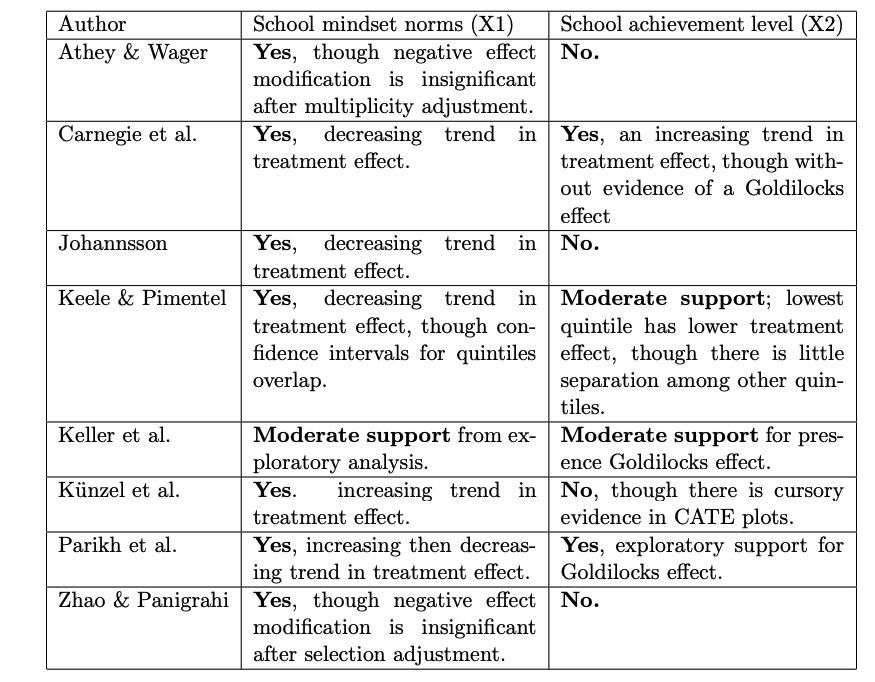

In [91]:
Image(filename = "../img/acic_het.png", width = 400, height = 300)

### 2.5.4 Individual Treatment Effects <a class="anchor" id="ite254"></a>

Probably one of the main benefits of the Bayesian approach is that we can get a distribution of the estimated treatment effect for each student (a.k.a., individual treatment effect). For instance, we show this for a sample student below.

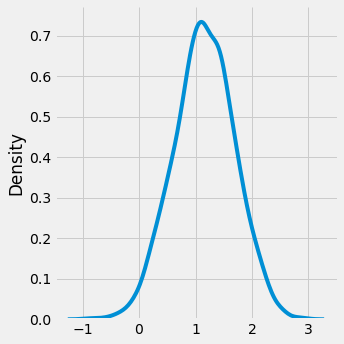

In [252]:
student = 989
ite = samples['tau_unit'][:,student] # same as samples['y1'][:,student] - samples['y0'][:,student]
sns.displot(ite, kind="kde")

## 2.6 A Hierachical Model <a class="anchor" id="hierarchical26"></a>

In [241]:
_, c = np.unique(df['schoolid'], return_counts=True)
c

array([ 72, 321, 201, 292, 189, 141, 120, 152, 154, 192,  21,  22,  46,
        24, 106, 226, 128, 178, 108, 161, 187,  42,  78, 107, 341, 224,
       143, 230, 107, 117,  14,  47,  50, 172,  54,  55, 109,  55,  78,
        63,  76,  74,  46,  60, 113, 141, 325,  88,  92,  45,  29,  47,
        35,  53,  44, 121, 211, 393, 196,  51, 114, 529,  95, 328,  43,
       186, 197, 104, 225,  46,  37, 233, 270, 258, 163, 196])

In [54]:
X, z, y, a_effects, m_effects, i_effects = pre_process_data(df, standardize_x=False, interactions=True, 
                                                            p_score=pscore, drop_first=False)

s_effects = ['XC_0','XC_1','XC_2','XC_3','XC_4','X1', 
             'X2','X3','X4','X5']
ns_effects = ['S3','C2','C3','C1_1','C1_2','C1_3','C1_4',
              'C1_5','C1_6','C1_7','C1_8','C1_9','C1_10',
              'C1_11','C1_12','C1_13','C1_14','C1_15','p_score']
sz_effects = ['Z_XC_0','Z_XC_1','Z_XC_2','Z_XC_3','Z_XC_4','Z_X1',
              'Z_X2','Z_X3','Z_X4','Z_X5']
nsz_effects = ['Z_S3','Z_C2','Z_C3','Z_C1_1','Z_C1_2', 'Z_C1_3',
               'Z_C1_4','Z_C1_5','Z_C1_6','Z_C1_7','Z_C1_8',
               'Z_C1_9','Z_C1_10','Z_C1_11','Z_C1_12','Z_C1_13',
               'Z_C1_14','Z_C1_15','Z_p_score']

# Get indexes of each effect group
idx_s_effects = [a_effects.index(i) for i in s_effects]
idx_ns_effects = [a_effects.index(i) for i in ns_effects]
idx_sz_effects = [a_effects.index(i) for i in sz_effects]
idx_nsz_effects = [a_effects.index(i) for i in nsz_effects]

array([76, 76, 76, ...,  1,  1,  1])

In [64]:
stan_data_mbi_h = {'N':      X.shape[0], 
                   'J':      len(df['schoolid'].unique()),
                   'school': df['schoolid'].values,
                   'N_s':    len(idx_s_effects),
                   'N_sz':   len(idx_sz_effects),
                   'N_ns':   len(idx_ns_effects),
                   'N_nsz':  len(idx_nsz_effects),
                   'x_s':    X[:,idx_s_effects],
                   'x_sz':   X[:,idx_sz_effects],
                   'x_ns':   X[:,idx_ns_effects],
                   'x_nsz':  X[:,idx_nsz_effects],
                   'y':      y,
                   'z':      z,
                   'rho':    0.0}
                   
sm = pystan.StanModel('../stan/stan_mbi_hierarchical.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_mbi_h = sm.sampling(data=stan_data_mbi_h, iter=1000, chains=4, seed=194838)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39b6e9ef44b71bb339cdf8eb7c8f13a9 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [65]:
summary_stan_fit_h = stan_model_summary(fit_mbi_h)

In [101]:
summary_stan_fit_h.loc[['tau_fs']]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
tau_fs,0.24053,0.000185,0.008302,0.224353,0.234763,0.240332,0.246358,0.257057,2010.645064,0.998317


In [95]:
#res = [a_effects[i] for i in idx_sz_effects]
#print(res)
#print(sz_effects)
#sz_effects.index('Z_X1')

In [96]:
samples_h = fit_mbi_h.extract(permuted=True)
Z_X1_samples_h = samples_h['beta_sz'][:, sz_effects.index('Z_X1')]
Z_X2_samples_h = samples_h['beta_sz'][:, sz_effects.index('Z_X2')]

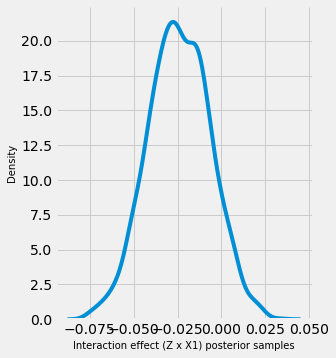

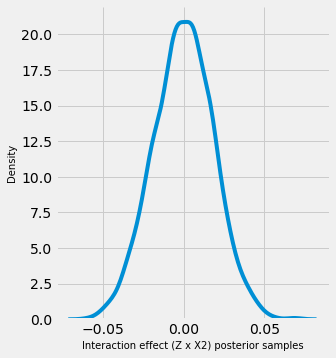

In [97]:
g1 = sns.displot(Z_X1_samples_h, kind="kde")
g1.set_axis_labels("Interaction effect (Z x X1) posterior samples", 
                   "Density", fontsize=10)

g2 = sns.displot(Z_X2_samples_h, kind="kde")
g2.set_axis_labels("Interaction effect (Z x X2) posterior samples", 
                   "Density", fontsize=10)

In [99]:
stan_utility.utils.check_energy(fit_mbi)

stan_utility.utils.check_div(fit_mbi)

E-BFMI indicated no pathological behavior
0.0 of 2000 iterations ended with a divergence (0.0%)


In [200]:
print(samples_h['alpha'].shape); 
print(samples_h['mu_alpha'].shape)
print(samples['alpha'].shape)
print(df['schoolid'].values) # CHECK if alphas are from 1:76 or 76:1!!!
#fit_mbi_h.data['school']
samples_h['mu_alpha'].shape

(2000, 76)
(2000,)
(2000,)
[76 76 76 ...  1  1  1]


(2000,)

In [215]:
def unique_nonsort(array):
    uniq, index, counts = np.unique(array, return_index=True, return_counts=True)
    return uniq[index.argsort()], counts[index.argsort()]

s_id, counts = unique_nonsort(df['schoolid'])
#s_id, counts = np.unique(df['schoolid'], return_counts=True)
df_school1 = pd.DataFrame({'schoolid': s_id, 'n': counts, 
                           'alpha_mean':np.mean(samples_h['alpha'], axis=0)})

df_school1 = df_school1.sort_values(by=['n'])
df_school1
#plt.scatter(list(range(1,77,1)), y = df_school1['alpha_mean'])  
#plt.scatter(x=df_school1['n'] , y = df_school1['alpha_mean'])  
#plt.axhline(y = np.mean(samples_h['mu_alpha']), color = 'r', linestyle = '-')
#plt.axhline(y = np.mean(samples['alpha']), color = 'b', linestyle = '-')



,schoolid,n,alpha_mean
45,31,14,-0.190935
65,11,21,-0.224693
64,12,22,-0.881747
62,14,24,-0.495989
25,51,29,-0.567559
...,...,...,...
29,47,325,-0.159118
12,64,328,-0.552742
51,25,341,-0.671012
18,58,393,-0.285117


# References <a class="anchor" id="ref"></a>

Carvalho, C., Feller, A., Murray, J., Woody, S., and Yeager, D. Assessing Treatment Effect Variation in Observational Studies: Results from a Data Challenge, (2019). https://arxiv.org/abs/1907.07592

Donald B. Rubin. Bayesian Inference for Causal Effects: The Role of Randomization. Ann. Statist. 6 (1) 34 - 58 (1978). https://doi.org/10.1214/aos/1176344064

Hahn, P.R., Murray, J.S., Carvalho, C.M. Bayesian Regression Tree Models for Causal Inference: Regularization, Confounding, and Heterogeneous Effects (with Discussion). Bayesian Analysis. 15 (3) 965 - 1056 (2020). https://doi.org/10.1214/19-BA1195

Hansen, Ben B. The Prognostic Analogue of the Propensity Score. Biometrika 95 (2), 481–88, (2008). https://doi.org/10.1093/biomet/asn004.

Yeager, D.S., Hanselman, P., Walton, G.M. et al. A national experiment reveals where a growth mindset improves achievement. Nature 573, 364–369 (2019). https://doi.org/10.1038/s41586-019-1466-y